# 🎓 Multimodal Emotion Recognition - 3-CLASS VERSION

## Emotion Mapping:
| Original (7) | Mapped (3) |
|--------------|------------|
| Joy, Surprise | **Positive** |
| Neutral | **Neutral** |
| Anger, Sadness, Fear, Disgust | **Negative** |

In [1]:
# -----------------------------------------------------------------------------
# 1. IMPORTS & CONFIGURATION
# -----------------------------------------------------------------------------
import os, glob, random, warnings, numpy as np, pandas as pd, librosa
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
from tqdm.auto import tqdm

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from transformers import AutoModel, AutoTokenizer, Wav2Vec2FeatureExtractor, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import whisper

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

class Config:
    ROOT_DIR = os.path.abspath("../../data/MELD.Raw")
    USE_SYNTHETIC_DATA = False
    
    TEXT_MODEL = "roberta-base"
    AUDIO_MODEL = "microsoft/wavlm-base-plus"
    NUM_CLASSES = 3  # Changed from 7 to 3!
    HIDDEN_DIM = 768
    PROJECTED_DIM = 256
    DROPOUT = 0.3
    UNFREEZE_LAST_N = 2
    
    BATCH_SIZE = 4
    GRAD_ACCUMULATION = 4
    EPOCHS = 10
    MAX_AUDIO_LEN = 16000 * 6
    MAX_TEXT_LEN = 64
    ENCODER_LR = 1e-5
    CLASSIFIER_LR = 5e-4
    PATIENCE = 3

# 3-CLASS LABELS
EMOTION_LABELS = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
EMOTION_COLORS = {'Negative': '#ef4444', 'Neutral': '#808080', 'Positive': '#22c55e'}

print(f"✅ 3-CLASS Config | ROOT_DIR: {Config.ROOT_DIR}")

🚀 Device: NVIDIA GeForce RTX 4060 Laptop GPU
✅ 3-CLASS Config | ROOT_DIR: c:\Users\Mohammed Hassan\Zewail\Senior Project\Research and Test\Multimodal Fusion - Emotion\data\MELD.Raw


In [2]:
# -----------------------------------------------------------------------------
# 2. MODEL (Same architecture, just 3 output classes)
# -----------------------------------------------------------------------------
class MultimodalFusionNet3Class(nn.Module):
    def __init__(self, config):
        super().__init__()
        print(f"   Loading {config.TEXT_MODEL}...")
        self.text_encoder = AutoModel.from_pretrained(config.TEXT_MODEL)
        print(f"   Loading {config.AUDIO_MODEL}...")
        self.audio_encoder = AutoModel.from_pretrained(config.AUDIO_MODEL)
        
        # Partial freeze
        for p in self.text_encoder.parameters(): p.requires_grad = False
        for p in self.audio_encoder.parameters(): p.requires_grad = False
        for i in range(len(self.text_encoder.encoder.layer) - config.UNFREEZE_LAST_N, len(self.text_encoder.encoder.layer)):
            for p in self.text_encoder.encoder.layer[i].parameters(): p.requires_grad = True
        for i in range(len(self.audio_encoder.encoder.layers) - config.UNFREEZE_LAST_N, len(self.audio_encoder.encoder.layers)):
            for p in self.audio_encoder.encoder.layers[i].parameters(): p.requires_grad = True
        print(f"   Unfroze last {config.UNFREEZE_LAST_N} layers")
        
        self.text_proj = nn.Sequential(nn.Linear(config.HIDDEN_DIM, config.PROJECTED_DIM), nn.GELU(), nn.Dropout(config.DROPOUT))
        self.audio_proj = nn.Sequential(nn.Linear(config.HIDDEN_DIM, config.PROJECTED_DIM), nn.GELU(), nn.Dropout(config.DROPOUT))
        
        self.classifier = nn.Sequential(
            nn.Linear(config.PROJECTED_DIM * 2, 256), nn.GELU(), nn.Dropout(config.DROPOUT),
            nn.Linear(256, 128), nn.GELU(), nn.Dropout(config.DROPOUT),
            nn.Linear(128, config.NUM_CLASSES)  # 3 classes!
        )
        
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        print(f"   Trainable: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")
    
    def forward(self, input_ids, attention_mask, audio_values):
        text_embed = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        audio_embed = torch.mean(self.audio_encoder(input_values=audio_values).last_hidden_state, dim=1)
        fused = torch.cat([self.text_proj(text_embed), self.audio_proj(audio_embed)], dim=1)
        return self.classifier(fused)

print("✅ 3-Class Model Defined")

✅ 3-Class Model Defined


In [3]:
# -----------------------------------------------------------------------------
# 3. DATASET with 7→3 CLASS MAPPING
# -----------------------------------------------------------------------------
class MELD_3Class_Dataset(Dataset):
    def __init__(self, root_dir, split="train", config=Config, synthetic=False):
        self.root_dir, self.split, self.config, self.synthetic = root_dir, split, config, synthetic
        
        # 7-class to 3-class mapping
        self.emotion_map = {
            'anger': 0,    # Negative
            'sadness': 0,  # Negative
            'fear': 0,     # Negative
            'disgust': 0,  # Negative
            'neutral': 1,  # Neutral
            'joy': 2,      # Positive
            'surprise': 2  # Positive
        }
        
        self.tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL)
        self.audio_processor = Wav2Vec2FeatureExtractor.from_pretrained(config.AUDIO_MODEL)
        
        if not synthetic:
            csv_path = os.path.join(root_dir, f"{split}_sent_emo.csv")
            self.data = pd.read_csv(csv_path) if os.path.exists(csv_path) else pd.DataFrame()
            self.video_map = {os.path.basename(f): f for f in glob.glob(os.path.join(root_dir, split, "**/*.mp4"), recursive=True)}
            
            # Show class distribution
            if len(self.data) > 0:
                labels_3class = self.data['Emotion'].str.lower().map(self.emotion_map)
                dist = labels_3class.value_counts().sort_index()
                print(f"   [{split}] {len(self.data)} samples | Neg:{dist.get(0,0)} Neu:{dist.get(1,0)} Pos:{dist.get(2,0)}")
    
    def __len__(self): return 100 if self.synthetic else len(self.data)
    
    def __getitem__(self, idx):
        if self.synthetic:
            text, label = "Test.", random.randint(0, 2)
            audio_raw = np.random.uniform(-1, 1, 16000).astype(np.float32)
        else:
            row = self.data.iloc[idx]
            text = str(row['Utterance'])
            label = self.emotion_map.get(row['Emotion'].lower(), 1)  # Default to neutral
            
            fp = self.video_map.get(f"dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.mp4")
            try: audio_raw, _ = librosa.load(fp, sr=16000, duration=6.0) if fp else (np.zeros(16000), 16000)
            except: audio_raw = np.zeros(16000, dtype=np.float32)
        
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.config.MAX_TEXT_LEN, return_tensors="pt")
        audio = self.audio_processor(audio_raw, sampling_rate=16000, return_tensors="pt", padding=True).input_values[0]
        tgt = self.config.MAX_AUDIO_LEN
        audio = torch.cat([audio, torch.zeros(tgt - audio.shape[0])]) if audio.shape[0] < tgt else audio[:tgt]
        
        return {'input_ids': inputs['input_ids'].squeeze(0), 'attention_mask': inputs['attention_mask'].squeeze(0), 'audio_values': audio, 'labels': torch.tensor(label)}

print("✅ 3-Class Dataset Defined")

✅ 3-Class Dataset Defined


In [4]:
# -----------------------------------------------------------------------------
# 4. TRAINING
# -----------------------------------------------------------------------------
def train_3class():
    train_ds = MELD_3Class_Dataset(Config.ROOT_DIR, "train", Config, Config.USE_SYNTHETIC_DATA)
    val_ds = MELD_3Class_Dataset(Config.ROOT_DIR, "dev", Config, Config.USE_SYNTHETIC_DATA)
    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False)
    
    model = MultimodalFusionNet3Class(Config).to(DEVICE)
    
    # Balanced class weights for 3 classes
    class_weights = torch.tensor([1.5, 0.5, 1.2]).to(DEVICE)  # Neg, Neu, Pos
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    enc_params = [p for n, p in model.named_parameters() if p.requires_grad and 'encoder' in n]
    cls_params = [p for n, p in model.named_parameters() if p.requires_grad and 'encoder' not in n]
    optimizer = optim.AdamW([{'params': enc_params, 'lr': Config.ENCODER_LR}, {'params': cls_params, 'lr': Config.CLASSIFIER_LR}], weight_decay=0.01)
    
    total_steps = len(train_loader) * Config.EPOCHS // Config.GRAD_ACCUMULATION
    scheduler = get_linear_schedule_with_warmup(optimizer, total_steps // 10, total_steps)
    scaler = GradScaler()
    
    history, best_f1, patience = {'loss': [], 'acc': [], 'f1': []}, 0, 0
    print(f"\n🔥 Training 3-CLASS model...")
    
    for epoch in range(Config.EPOCHS):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")
        
        for i, batch in enumerate(pbar):
            ids, mask, audio, labels = [batch[k].to(DEVICE) for k in ['input_ids', 'attention_mask', 'audio_values', 'labels']]
            with autocast(): loss = criterion(model(ids, mask, audio), labels) / Config.GRAD_ACCUMULATION
            scaler.scale(loss).backward()
            if (i + 1) % Config.GRAD_ACCUMULATION == 0:
                scaler.step(optimizer); scaler.update(); scheduler.step(); optimizer.zero_grad()
            total_loss += loss.item() * Config.GRAD_ACCUMULATION
            pbar.set_postfix({'loss': f"{loss.item() * Config.GRAD_ACCUMULATION:.4f}"})
        
        # Validation
        model.eval()
        preds, truths = [], []
        with torch.no_grad():
            for batch in val_loader:
                ids, mask, audio, labels = [batch[k].to(DEVICE) for k in ['input_ids', 'attention_mask', 'audio_values', 'labels']]
                with autocast(): out = model(ids, mask, audio)
                preds.extend(torch.argmax(out, 1).cpu().numpy())
                truths.extend(labels.cpu().numpy())
        
        acc = 100 * np.mean(np.array(preds) == np.array(truths))
        f1 = 100 * f1_score(truths, preds, average='weighted')
        history['loss'].append(total_loss / len(train_loader))
        history['acc'].append(acc)
        history['f1'].append(f1)
        
        print(f"   ✅ Loss={total_loss/len(train_loader):.4f} | Acc={acc:.2f}% | F1={f1:.2f}%")
        
        if f1 > best_f1:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), "best_model_3class.pt")
            print(f"   💾 Saved! (Best F1={best_f1:.2f}%)")
        else:
            patience += 1
            if patience >= Config.PATIENCE: print(f"\n⏹️ Early stopping"); break
    
    model.load_state_dict(torch.load("best_model_3class.pt"))
    return model, history

trained_model, stats = train_3class()

   [train] 9989 samples | Neg:2331 Neu:4710 Pos:2948
   [dev] 1109 samples | Neg:326 Neu:470 Pos:313
   Loading roberta-base...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Loading microsoft/wavlm-base-plus...
   Unfroze last 2 layers
   Trainable: 28,910,891 / 219,585,907 (13.2%)

🔥 Training 3-CLASS model...


Epoch 1/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=1.0101 | Acc=66.28% | F1=64.68%
   💾 Saved! (Best F1=64.68%)


Epoch 2/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.8349 | Acc=63.30% | F1=63.62%


Epoch 3/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.7961 | Acc=67.81% | F1=67.89%
   💾 Saved! (Best F1=67.89%)


Epoch 4/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.7722 | Acc=70.24% | F1=69.91%
   💾 Saved! (Best F1=69.91%)


Epoch 5/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.7530 | Acc=69.97% | F1=69.61%


Epoch 6/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.7304 | Acc=67.09% | F1=67.28%


Epoch 7/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.7090 | Acc=70.42% | F1=70.39%
   💾 Saved! (Best F1=70.39%)


Epoch 8/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.6867 | Acc=67.81% | F1=68.03%


Epoch 9/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.6701 | Acc=68.71% | F1=68.59%


Epoch 10/10:   0%|          | 0/2498 [00:00<?, ?it/s]

   ✅ Loss=0.6681 | Acc=67.90% | F1=68.02%

⏹️ Early stopping


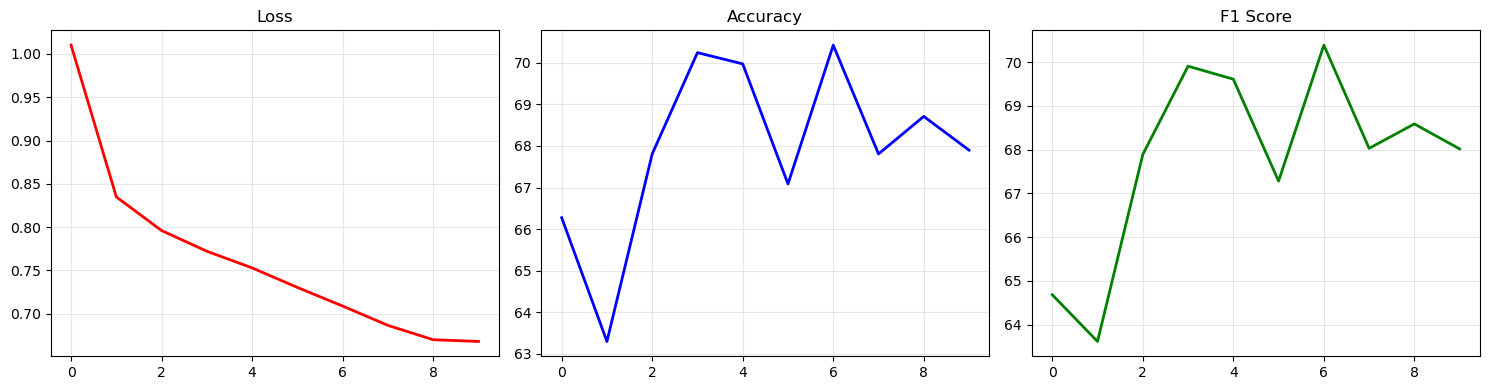


🏆 BEST RESULTS:
   Accuracy: 70.42%
   F1 Score: 70.39%


In [5]:
# -----------------------------------------------------------------------------
# 5. RESULTS & CONFUSION MATRIX
# -----------------------------------------------------------------------------
# Training plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(stats['loss'], 'r-', lw=2); axes[0].set_title('Loss'); axes[0].grid(True, alpha=0.3)
axes[1].plot(stats['acc'], 'b-', lw=2); axes[1].set_title('Accuracy'); axes[1].grid(True, alpha=0.3)
axes[2].plot(stats['f1'], 'g-', lw=2); axes[2].set_title('F1 Score'); axes[2].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print(f"\n🏆 BEST RESULTS:")
print(f"   Accuracy: {max(stats['acc']):.2f}%")
print(f"   F1 Score: {max(stats['f1']):.2f}%")

   [test] 2610 samples | Neg:671 Neu:1256 Pos:683


Testing:   0%|          | 0/653 [00:00<?, ?it/s]


📊 TEST SET RESULTS:
              precision    recall  f1-score   support

    Negative       0.59      0.58      0.58       671
     Neutral       0.80      0.73      0.76      1256
    Positive       0.61      0.73      0.66       683

    accuracy                           0.69      2610
   macro avg       0.67      0.68      0.67      2610
weighted avg       0.70      0.69      0.69      2610



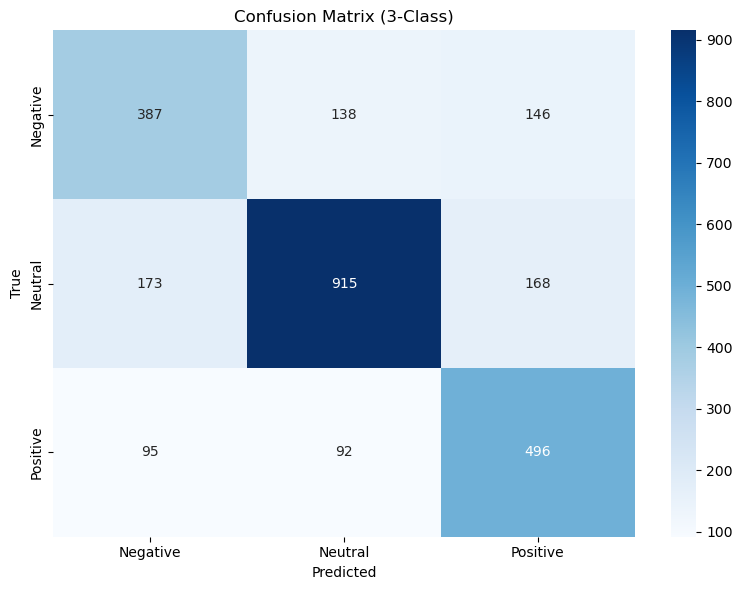

In [6]:
# -----------------------------------------------------------------------------
# 6. TEST SET EVALUATION
# -----------------------------------------------------------------------------
test_ds = MELD_3Class_Dataset(Config.ROOT_DIR, "test", Config)
test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False)

trained_model.eval()
preds, truths = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        ids, mask, audio, labels = [batch[k].to(DEVICE) for k in ['input_ids', 'attention_mask', 'audio_values', 'labels']]
        with autocast(): out = trained_model(ids, mask, audio)
        preds.extend(torch.argmax(out, 1).cpu().numpy())
        truths.extend(labels.cpu().numpy())

# Classification Report
print("\n📊 TEST SET RESULTS:")
print(classification_report(truths, preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (3-Class)')
plt.tight_layout(); plt.show()

---
# 📞 Timeline Analyzer (3-Class)

In [7]:
# -----------------------------------------------------------------------------
# 7. TIMELINE ANALYZER
# -----------------------------------------------------------------------------
class TimelineAnalyzer3Class:
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        
        print("⏳ Loading Whisper...")
        self.whisper = whisper.load_model("small", device=device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL)
        self.audio_processor = Wav2Vec2FeatureExtractor.from_pretrained(config.AUDIO_MODEL)
        print("✅ Ready")
    
    def analyze(self, audio_path):
        print(f"\n📞 Analyzing: {os.path.basename(audio_path)}")
        result = self.whisper.transcribe(audio_path)
        segments = result['segments']
        print(f"   {len(segments)} segments found")
        
        if not segments: return pd.DataFrame()
        
        full_audio, _ = librosa.load(audio_path, sr=16000)
        results = []
        self.model.eval()
        
        for seg in tqdm(segments, desc="Classifying"):
            start, end, text = seg['start'], seg['end'], seg['text'].strip()
            if end - start < 0.3: continue
            
            audio_slice = full_audio[int(start * 16000):int(end * 16000)]
            if len(audio_slice) < 1600: continue
            
            audio_input = self.audio_processor(audio_slice, sampling_rate=16000, return_tensors="pt", padding=True).input_values[0]
            tgt = self.config.MAX_AUDIO_LEN
            audio_input = torch.cat([audio_input, torch.zeros(tgt - audio_input.shape[0])]) if audio_input.shape[0] < tgt else audio_input[:tgt]
            
            text_input = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.config.MAX_TEXT_LEN, return_tensors="pt")
            
            with torch.no_grad():
                ids, mask = text_input['input_ids'].to(self.device), text_input['attention_mask'].to(self.device)
                audio = audio_input.unsqueeze(0).to(self.device)
                with autocast(): logits = self.model(ids, mask, audio)
                probs = torch.softmax(logits, dim=1)
                pred_idx = torch.argmax(probs, dim=1).item()
            
            results.append({'start': round(start, 2), 'end': round(end, 2), 'text': text, 'emotion': EMOTION_LABELS[pred_idx], 'confidence': round(probs[0, pred_idx].item(), 3)})
        
        return pd.DataFrame(results)
    
    def plot_timeline(self, df, title="Emotion Timeline"):
        if df.empty: return
        fig, ax = plt.subplots(figsize=(16, 3))
        for _, row in df.iterrows():
            color = EMOTION_COLORS[row['emotion']]
            ax.barh(0, row['end']-row['start'], left=row['start'], color=color, edgecolor='white', height=0.6)
            if row['end'] - row['start'] > 1.0:
                ax.text(row['start'] + (row['end']-row['start'])/2, 0, row['emotion'][:3], 
                       ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        ax.set_yticks([])
        ax.set_xlabel('Time (seconds)', fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlim(0, df['end'].max() + 0.5)
        patches = [mpatches.Patch(color=c, label=e) for e, c in EMOTION_COLORS.items() if e in df['emotion'].values]
        ax.legend(handles=patches, loc='upper right', ncol=len(patches))
        plt.tight_layout()
        plt.show()

print("✅ TimelineAnalyzer3Class Defined")

✅ TimelineAnalyzer3Class Defined


⏳ Loading Whisper...
✅ Ready
Found 2747 audio files

📞 Analyzing: dia100_utt15.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]

,start,end,text,emotion,confidence
0,0.0,1.0,Where's Leslie?,Neutral,0.814


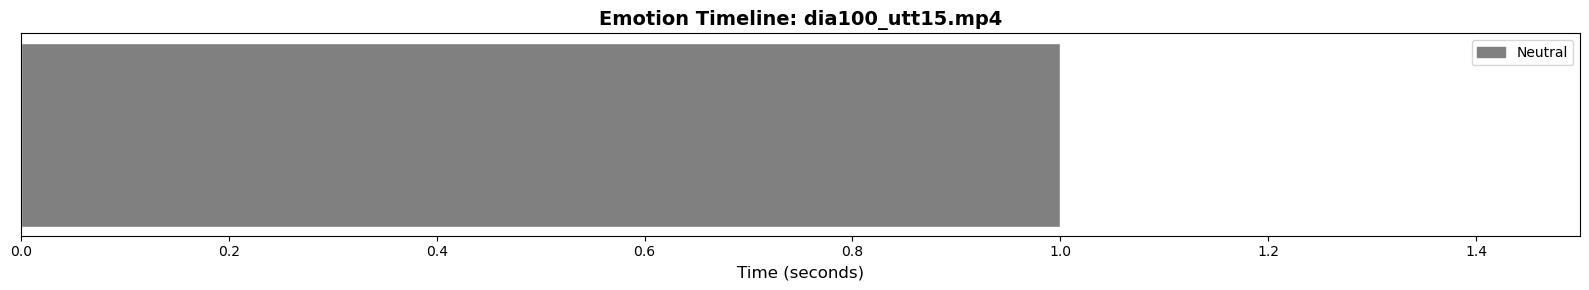

In [8]:
# -----------------------------------------------------------------------------
# 8. RUN SINGLE ANALYSIS
# -----------------------------------------------------------------------------
analyzer = TimelineAnalyzer3Class(trained_model, Config, DEVICE)

# Get all MELD test files
meld_files = glob.glob(os.path.join(Config.ROOT_DIR, "test", "**/*.mp4"), recursive=True)
print(f"Found {len(meld_files)} audio files")

# Analyze a single sample
if meld_files:
    audio_path = meld_files[10]
    df = analyzer.analyze(audio_path)
    if not df.empty:
        display(df)
        analyzer.plot_timeline(df, f"Emotion Timeline: {os.path.basename(audio_path)}")


📞 Analyzing: dia0_utt0.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia0_utt1.mp4
   3 segments found


Classifying:   0%|          | 0/3 [00:00<?, ?it/s]


📞 Analyzing: dia0_utt2.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt0.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt1.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt10.mp4
   2 segments found


Classifying:   0%|          | 0/2 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt11.mp4
   2 segments found


Classifying:   0%|          | 0/2 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt12.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt13.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt14.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt15.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt16.mp4
   3 segments found


Classifying:   0%|          | 0/3 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt17.mp4
   3 segments found


Classifying:   0%|          | 0/3 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt18.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📞 Analyzing: dia100_utt19.mp4
   1 segments found


Classifying:   0%|          | 0/1 [00:00<?, ?it/s]


📝 All Results:


,start,end,text,emotion,confidence,file
0,0.00,2.24,Why don't your coffee mugs have numbers on the...,Neutral,0.555,dia0_utt0.mp4
1,0.00,2.80,"Uh, that's a moniker who can keep track",Neutral,0.743,dia0_utt1.mp4
2,2.80,4.80,"that way if one of them's missing, she can be ...",Neutral,0.849,dia0_utt1.mp4
3,4.80,6.80,where's number 27?,Neutral,0.873,dia0_utt1.mp4
4,0.00,1.00,You know what?,Neutral,0.573,dia0_utt2.mp4
5,0.00,2.56,Why are you taking care of you with no problem...,Negative,0.460,dia100_utt0.mp4
6,0.00,2.00,"You guys feel safe, right?",Neutral,0.827,dia100_utt1.mp4
7,0.00,1.00,I broke it.,Negative,0.594,dia100_utt10.mp4
8,1.00,4.00,"All right, well, that's just the way things go.",Neutral,0.516,dia100_utt10.mp4
9,0.00,1.00,I broke it.,Negative,0.594,dia100_utt11.mp4


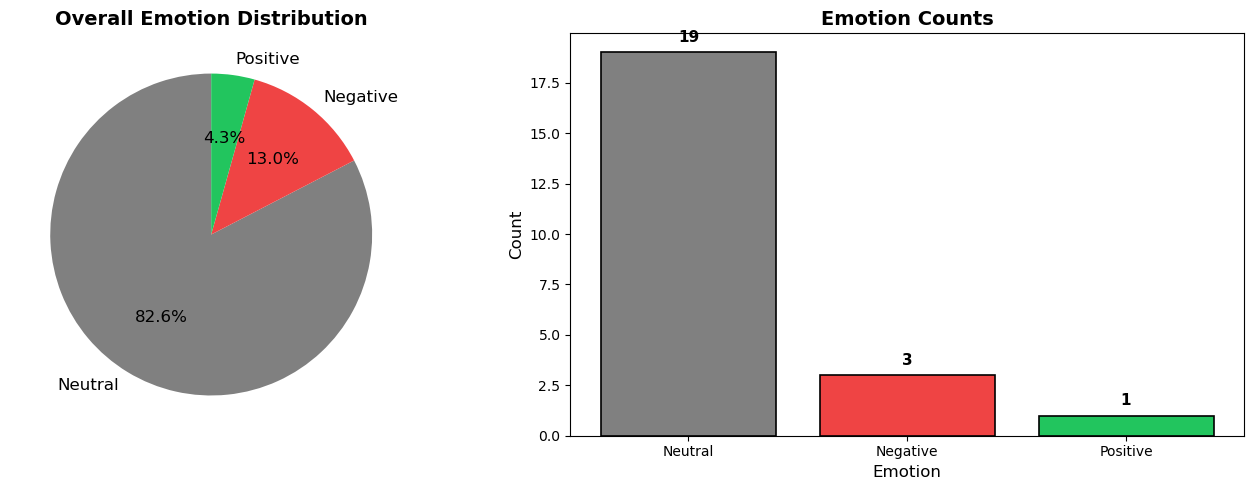

In [9]:
# -----------------------------------------------------------------------------
# 9. BATCH ANALYSIS (Multiple Files)
# 🔧 Change max_files to analyze more samples!
# -----------------------------------------------------------------------------
def analyze_batch(file_paths, max_files=15):
    """Analyze multiple audio files and show overall distribution."""
    all_results = []
    
    for path in file_paths[:max_files]:
        df = analyzer.analyze(path)
        if not df.empty:
            df['file'] = os.path.basename(path)
            all_results.append(df)
    
    if all_results:
        combined = pd.concat(all_results, ignore_index=True)
        
        # Show results table
        print('\n📝 All Results:')
        display(combined)
        
        # Emotion distribution visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Pie chart
        dist = combined['emotion'].value_counts()
        colors = [EMOTION_COLORS[e] for e in dist.index]
        axes[0].pie(dist.values, labels=dist.index, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
        axes[0].set_title('Overall Emotion Distribution', fontsize=14, fontweight='bold')
        
        # Bar chart
        axes[1].bar(dist.index, dist.values, color=colors, edgecolor='black', linewidth=1.2)
        axes[1].set_title('Emotion Counts', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=12)
        axes[1].set_xlabel('Emotion', fontsize=12)
        for i, (emotion, count) in enumerate(zip(dist.index, dist.values)):
            axes[1].text(i, count + 0.5, str(count), ha='center', fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return combined
    return pd.DataFrame()

# 🔧 CHANGE max_files TO ANALYZE MORE SAMPLES (e.g., 15, 20, 30)
batch_results = analyze_batch(meld_files, max_files=15)